In [1]:
import numpy as np
import sklearn.datasets
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# import jax
# import jax.numpy as jnp
from tqdm import tqdm



In [2]:
d = 10

A_1 = sklearn.datasets.make_spd_matrix(d)
A_2 = sklearn.datasets.make_spd_matrix(d)
B_1 = sklearn.datasets.make_spd_matrix(d)
B_2 = sklearn.datasets.make_spd_matrix(d)
C = sklearn.datasets.make_spd_matrix(d)
phi = np.random.uniform(low=0.0, high=1.0, size=d)
theta = np.random.uniform(low=0.0, high=1.0, size=d)
X = np.hstack((theta, phi))


## On the Convergence of Single-Call Stochastic Extra-Gradient Methods

#### Variational inequalities.

$\mathcal{X}$  nonempty closed convex subset of $\mathbb{R}^d$

$V:\mathbb{R}^d\to\mathbb{R}^d$

Find $x^\star\in\mathcal{X}$ such that $\left<V(x^\star),x-x^\star\right> \geq0$ for all $x\in\mathcal{X}$

$\mathcal{X}=\Theta\times\Phi, \Theta\in \mathbb{R}^{d1} , \Phi  \in \mathbb{R}^{d2}$ and $V = (\nabla_{\theta}\mathcal{L}, -\nabla_{\phi}\mathcal{L} ), V_t=V(X_t)+Z_t$


The solutions correspond to the critical points of $\mathcal{L}$ 

If, in addition, is $\mathcal{L}$ is
convex-concave, any solution x is a global saddle-point, i.e.,

$$\mathcal{L}(\theta^\star,\phi)\leq\mathcal{L}(\theta^\star,\phi^\star)\leq\mathcal{L}(\theta,\phi^\star)\quad\text{for all }\theta\in\Theta\text{ and all }\phi\in\Phi $$




#### The Extra-Gradient algorithm.

\begin{aligned}X_{t+1/2}&=\Pi_{\mathcal{X}}(X_t-\gamma_tV_t)\\X_{t+1}&=\Pi_{\mathcal{X}}(X_t-\gamma_tV_{t+1/2})\end{aligned}

$$\Pi_{\mathcal{X}}(y):=\operatorname{arg}\operatorname*{min}_{x\in\mathcal{X}}\|y-x\|$$

Heuristically, the extra oracle call allows the algorithm
to “anticipate” the landscape of $V$

#### Single-call Extra-Gradient algorithm

\begin{aligned}X_{t+1/2}&=\Pi_{\mathcal{X}}(X_t-\gamma_tV_{t-1/2})\\X_{t+1}&=\Pi_{\mathcal{X}}(X_t-\gamma_tV_{t+1/2})\end{aligned}

\begin{aligned}\mathcal{L}(\theta,\phi)=2\epsilon_1\theta^\top A_1\theta+\epsilon_2\left(\theta^\top A_2\theta\right)^2-2\epsilon_1\phi^\top B_1\phi-\epsilon_2\left(\phi^\top B_2\phi\right)^2+4\theta^\top C\phi\end{aligned}

$$
\nabla \mathcal{L}_{\theta} = 2\epsilon_1 (A_1 + A_1^T) \theta + 2\epsilon_2 \theta^T A_2 \theta (A_2 + A_2^T) \theta + 4 C \phi
$$


$$
\nabla \mathcal{L}_{\phi} = -2\epsilon_1 (B_1 + B_1^T) \phi - 2\epsilon_2 \phi^T B_2 \phi (B_2 + B_2^T) \phi + 4 C \theta
$$

In [3]:
d = 10

A_1 = sklearn.datasets.make_spd_matrix(d)
A_2 = sklearn.datasets.make_spd_matrix(d)
B_1 = sklearn.datasets.make_spd_matrix(d)
B_2 = sklearn.datasets.make_spd_matrix(d)
C = sklearn.datasets.make_spd_matrix(d)
phi = np.random.uniform(low=0.0, high=1.0, size=d)
theta = np.random.uniform(low=0.0, high=1.0, size=d)
X = np.hstack((theta, phi))

In [4]:
def functional(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2):

    d = int(X.shape[0] / 2)
    theta = X[:d]
    phi = X[d:]

    return 2 * epsilon_1 * np.dot(theta, A_1 @ theta) + epsilon_2 * np.dot(theta, A_2 @ theta)**2 - 2 * epsilon_1 * np.dot(phi, B_1 @ phi) -  epsilon_2 * np.dot(phi, B_2 @ phi)**2 +  4 * np.dot(theta, C @ phi)

def functional_gradien(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2):
    theta = X[:d]
    phi = X[d:]

    nabla_theta = 2 * epsilon_1 * np.dot((A_1 + A_1.T), theta) + 2 * epsilon_2 * np.dot(theta, np.dot(A_2, theta)) * np.dot((A_2 + A_2.T), theta) + 4 * np.dot(C, phi)
    nabla_phi = - 2 * epsilon_1 * np.dot((B_1 + B_1.T), phi) - 2 * epsilon_2 * np.dot(phi, np.dot(B_2, phi)) * np.dot((B_2 + B_2.T), phi) + 4 * np.dot(C, theta)
  
    return np.hstack((nabla_theta, -nabla_phi))

# def EG():

In [5]:
def EG(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma, stochastic,sigma, K = 10**3, eps = 1e-5):


    criterions = np.array([])

    grad_0 = functional_gradien(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2) + np.random.normal(0, sigma) * stochastic

    X_step = X
    criterion = True
    i = 0
    oracl_calls = np.array([])
    oracls = 0

    j = 0

    while  i < K and criterion:


        X_half_step = X_step - gamma * (functional_gradien(A_1, A_2, B_1, B_2, C, X_step, epsilon_1, epsilon_2) + np.random.normal(0, sigma) * stochastic)
        oracls += 1

        X_step = X_step - gamma * (functional_gradien(A_1, A_2, B_1, B_2, C, X_half_step, epsilon_1, epsilon_2) + np.random.normal(0, sigma) * stochastic)
        oracls += 1

 

        tmp = np.linalg.norm(functional_gradien(A_1, A_2, B_1, B_2, C, X_step, epsilon_1, epsilon_2)) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)
        oracl_calls = np.append(oracl_calls, oracls)

        i += 1


    return criterions, oracl_calls

def EG_1(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma, stochastic, sigma, K = 10**3, eps = 1e-5):


    criterions = np.array([])

    grad_0 = functional_gradien(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2) + np.random.normal(0, sigma) * stochastic

    grad = grad_0
    X_half_step = X
    X_step = X
    criterion = True
    i = 0
    oracl_calls = np.array([])
    oracls = 1

    while  i < K and criterion:


        X_half_step = X_step - gamma * grad

        grad = functional_gradien(A_1, A_2, B_1, B_2, C, X_half_step, epsilon_1, epsilon_2) + np.random.normal(0, sigma) * stochastic

        oracls += 1

        X_step = X_step - gamma * grad 



        tmp = np.linalg.norm(grad) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)
        oracl_calls = np.append(oracl_calls, oracls)

        i += 1


    return criterions, oracl_calls




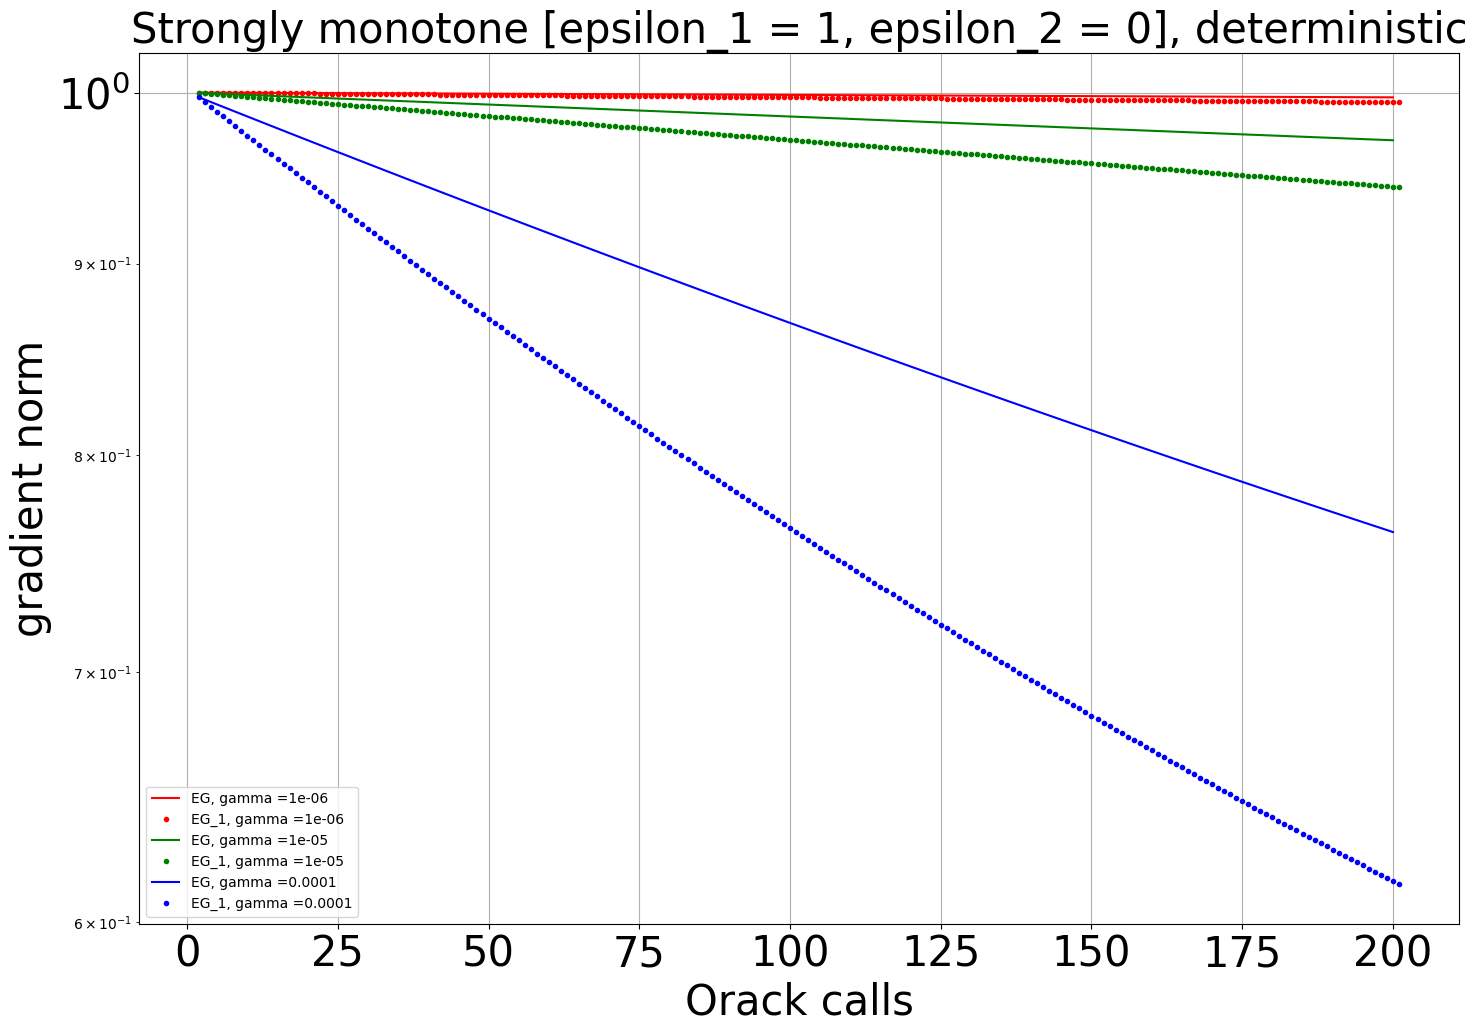

In [6]:
f,ax1 = plt.subplots(1,figsize = (15,10))
sigma = 0
stochastic = False
iters = 100
iters_1 = 200

epsilon_1 = 1
epsilon_2 = 0
gamma_array = np.array([1e-6, 1e-5, 1e-4])
colors = np.array(['red', 'green', 'blue'])

for i in range(gamma_array.shape[0]):


    criterions, oracl_calls = EG(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma_array[i],stochastic,sigma, K = iters, eps = 1e-10)
    plt.plot(oracl_calls, criterions, color=colors[i], label='EG, gamma ='+str(gamma_array[i]))

    criterions, oracl_calls = EG_1(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma_array[i],stochastic,sigma, K = iters_1, eps = 1e-10)
    plt.plot(oracl_calls, criterions, '.', color=colors[i], label='EG_1, gamma ='+str(gamma_array[i]))


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('Orack calls', fontsize = 30 )
ax1.set_ylabel('gradient norm', fontsize = 30 )

# ax1.set_ylabel('$$\frac{\\| \nabla f(x^k) \\|}{\\| \\nabla f(x^0) \\|}$$', fontsize = 30 )

ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Strongly monotone [epsilon_1 = 1, epsilon_2 = 0], deterministic', fontsize = 30)
plt.yscale('log')
plt.show()



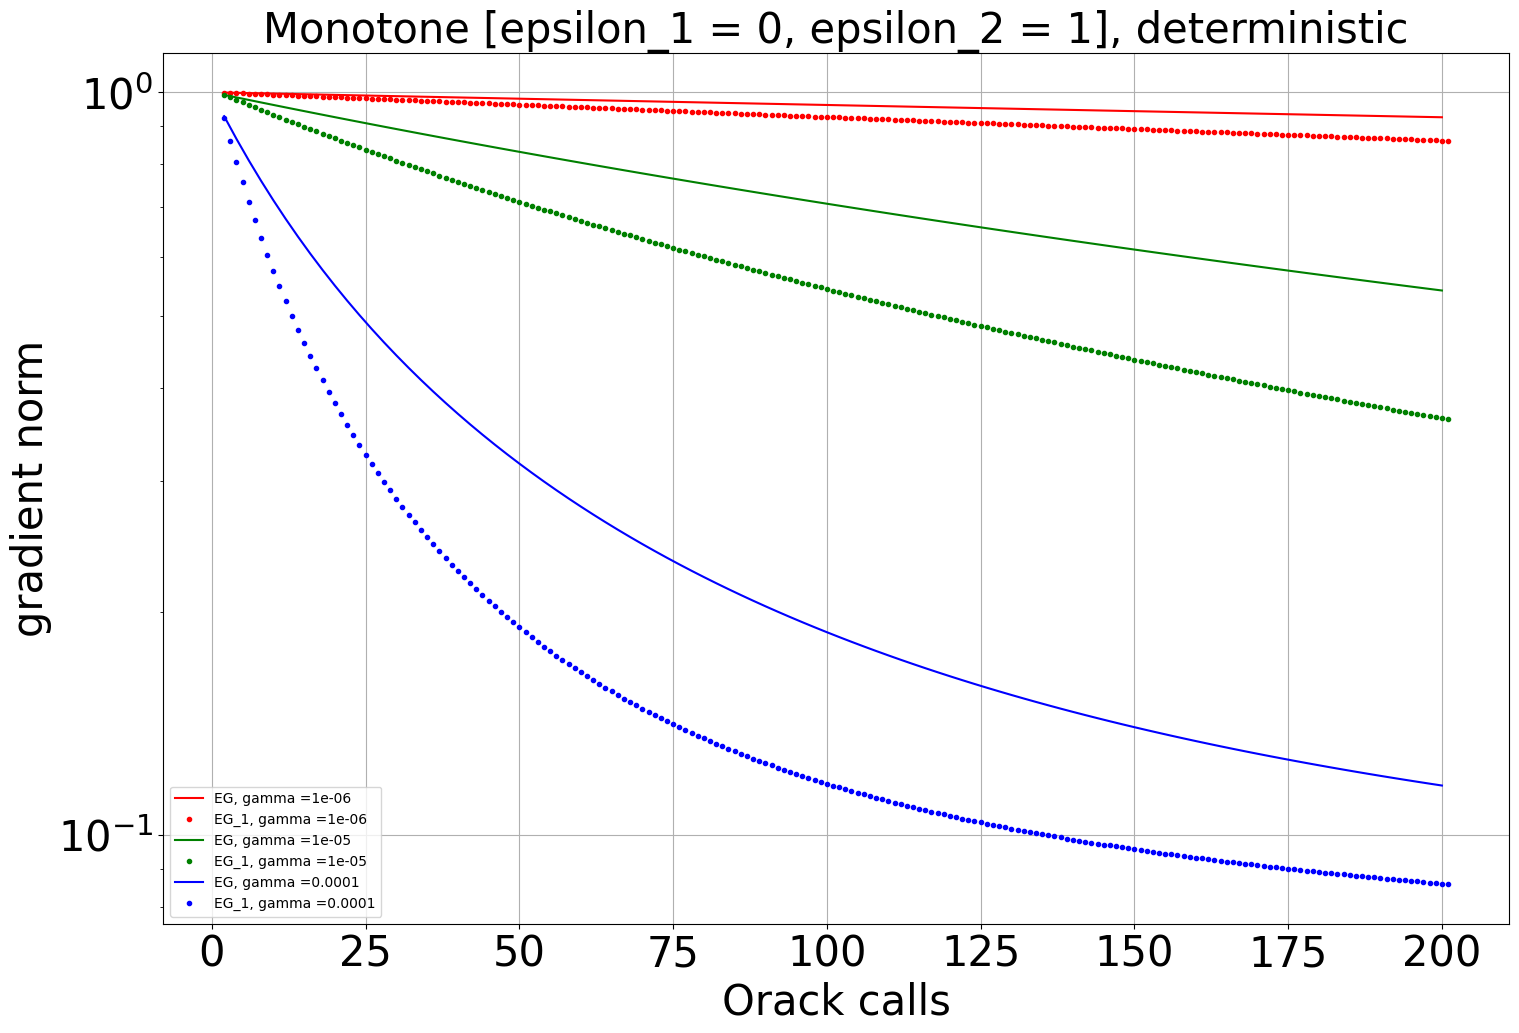

In [7]:
f,ax1 = plt.subplots(1,figsize = (15,10))
sigma = 0
stochastic = False
iters = 100
iters_1 = 200


epsilon_1 = 0
epsilon_2 = 1
gamma_array = np.array([1e-6, 1e-5, 1e-4])
colors = np.array(['red', 'green', 'blue'])


for i in range(gamma_array.shape[0]):


    criterions, oracl_calls = EG(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma_array[i],stochastic,sigma, K = iters, eps = 1e-10)
    plt.plot(oracl_calls, criterions, color=colors[i], label='EG, gamma ='+str(gamma_array[i]))

    criterions, oracl_calls = EG_1(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma_array[i],stochastic,sigma, K = iters_1, eps = 1e-10)
    plt.plot(oracl_calls, criterions, '.', color=colors[i], label='EG_1, gamma ='+str(gamma_array[i]))


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('Orack calls', fontsize = 30 )
ax1.set_ylabel('gradient norm', fontsize = 30 )

# ax1.set_ylabel('$$\frac{\\| \nabla f(x^k) \\|}{\\| \\nabla f(x^0) \\|}$$', fontsize = 30 )

ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Monotone [epsilon_1 = 0, epsilon_2 = 1], deterministic', fontsize = 30)
plt.yscale('log')
plt.show()


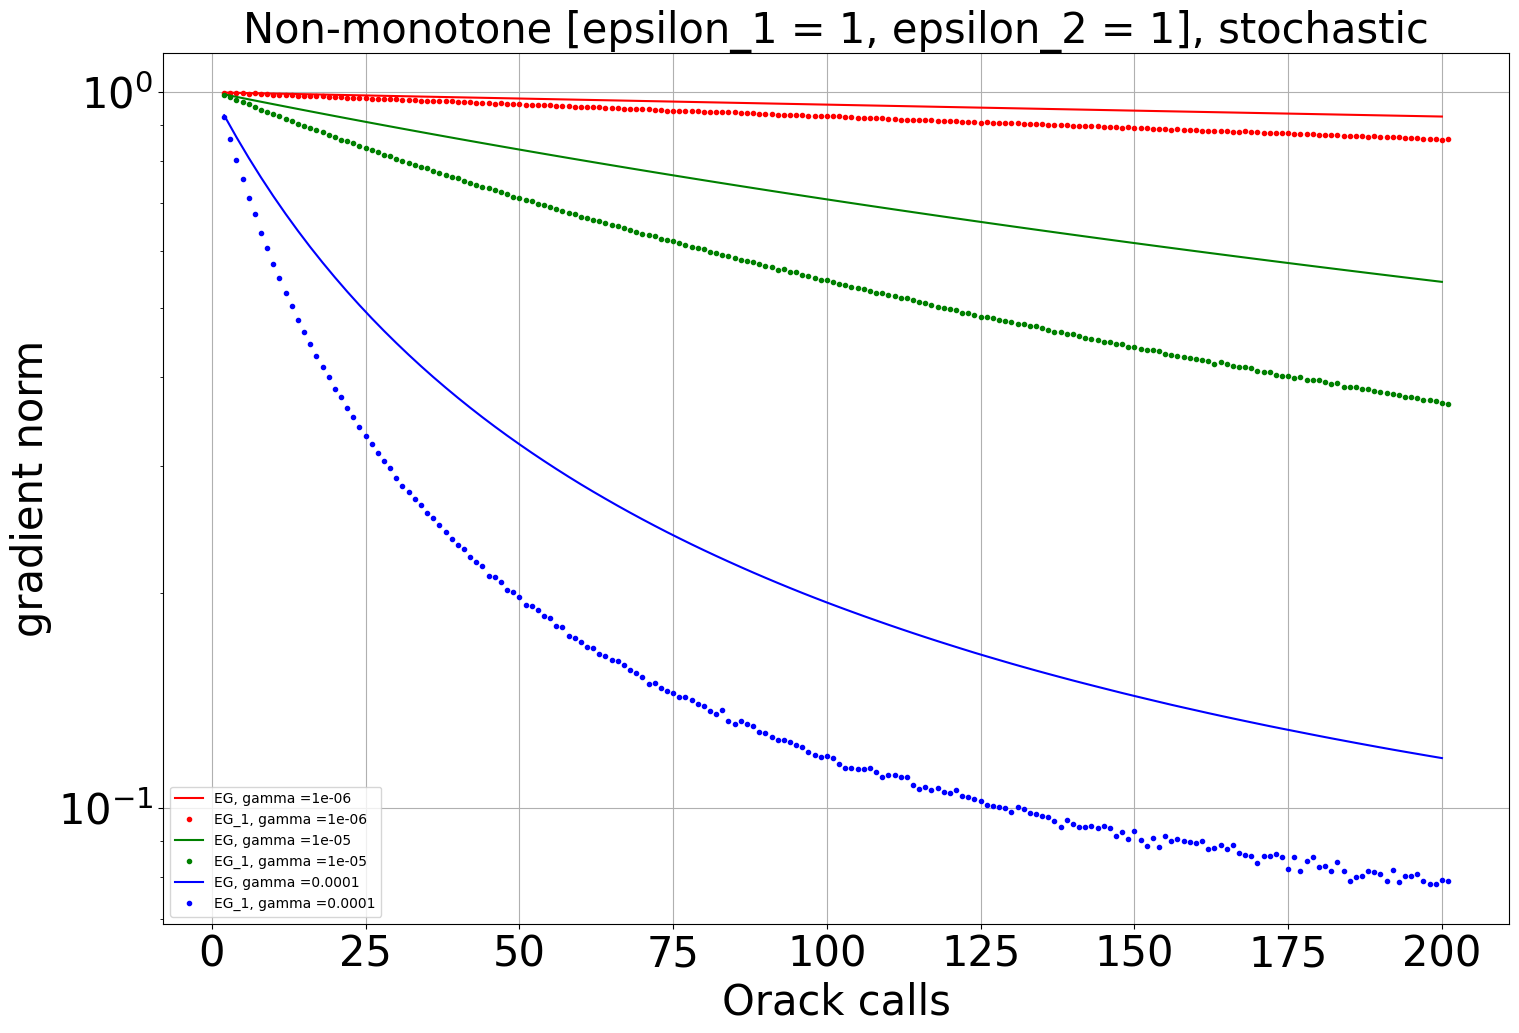

In [8]:

f,ax1 = plt.subplots(1,figsize = (15,10))
iters = 100
iters_1 = 200

sigma = 0.1
stochastic = 1
epsilon_1 = 1
epsilon_2 = 1
gamma_array = np.array([1e-6, 1e-5, 1e-4])
colors = np.array(['red', 'green', 'blue'])


for i in range(gamma_array.shape[0]):


    criterions, oracl_calls = EG(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma_array[i], stochastic,sigma, K = iters, eps = 1e-10)
    plt.plot(oracl_calls, criterions, color=colors[i], label='EG, gamma ='+str(gamma_array[i]))

    criterions, oracl_calls = EG_1(A_1, A_2, B_1, B_2, C, X, epsilon_1, epsilon_2, gamma_array[i], stochastic,sigma, K = iters_1, eps = 1e-10)
    plt.plot(oracl_calls, criterions, '.', color=colors[i], label='EG_1, gamma ='+str(gamma_array[i]))


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('Orack calls', fontsize = 30 )
ax1.set_ylabel('gradient norm', fontsize = 30 )

# ax1.set_ylabel('$$\frac{\\| \nabla f(x^k) \\|}{\\| \\nabla f(x^0) \\|}$$', fontsize = 30 )

ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Non-monotone [epsilon_1 = 1, epsilon_2 = 1], stochastic', fontsize = 30)
plt.yscale('log')
plt.show()
